# Optimizing a Double Moving Average Crossover Strategy using Bayesian Optimization and Sharpe Ratio

In [74]:
%pip install yfinance optuna matplotlib pandas numpy tabulate --quiet

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\medium\articles\sharpe_ratio_bayesian_optimizer\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Libraries

In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import optuna
from optuna.samplers import TPESampler

plt.style.use('dark_background')

## Download Data

In [76]:
def get_data(ticker="F", start="2015-01-01", end="2024-12-31"):
    df = yf.download(ticker, start=start, end=end)
    df.columns = df.columns.get_level_values(0)
    df = df[['Close']]
    return df

data = get_data()
data.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_10944\2035438419.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2015-01-02,8.742793
2015-01-05,8.401278
2015-01-06,8.321589
2015-01-07,8.560649
2015-01-08,8.776942


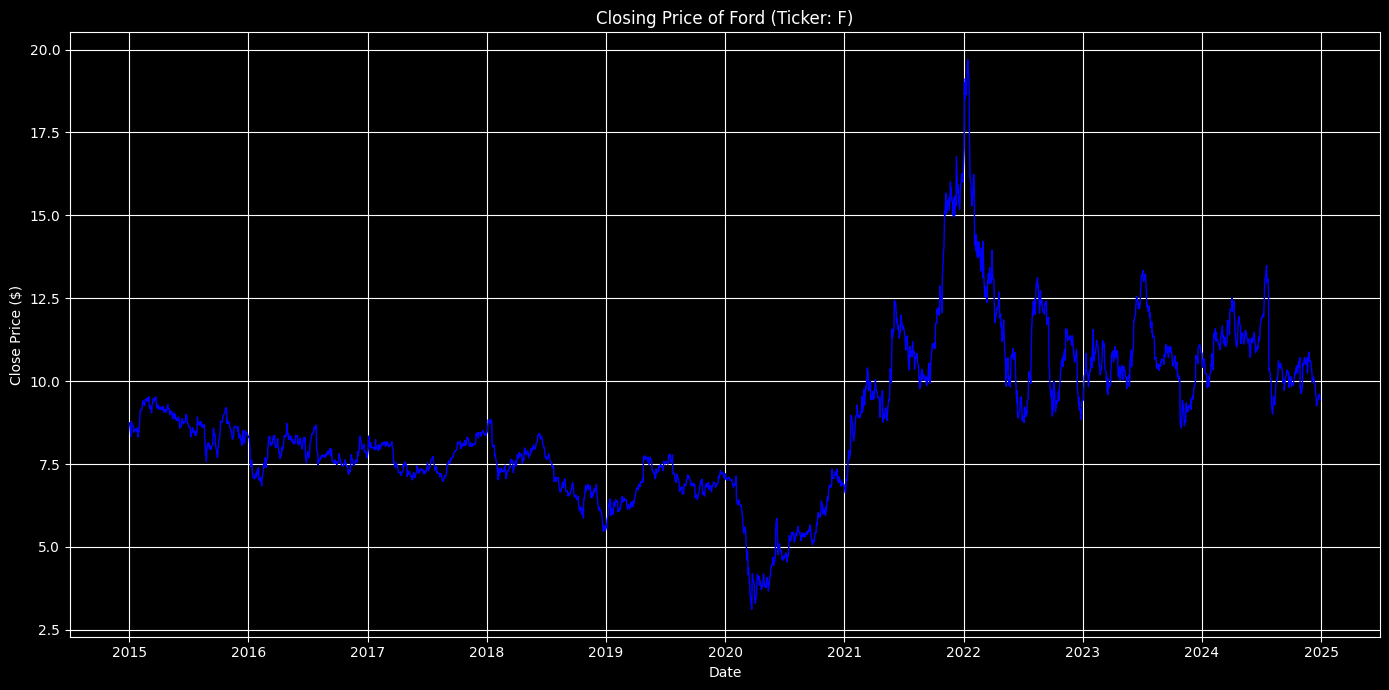

In [77]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], color='blue', linewidth=1)
plt.title('Closing Price of Ford (Ticker: F)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.tight_layout()
plt.savefig('closing_price_plot.png', dpi=300)
plt.show()

## Train/Test Split

In [78]:
# 80/20 train-test split
split_date = data.index[int(len(data) * 0.8)]
train_data = data[:split_date]
test_data = data[split_date:]
print(f"Train: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test:  {test_data.index[0].date()} to {test_data.index[-1].date()}")

Train: 2015-01-02 to 2022-12-29
Test:  2022-12-29 to 2024-12-30


## Strategy & Sharpe Logic

In [79]:
def apply_dmac(df, short_window, long_window):
    if short_window >= long_window:
        return pd.DataFrame()

    data = df.copy()
    data['short_ma'] = data['Close'].rolling(window=short_window).mean()
    data['long_ma'] = data['Close'].rolling(window=long_window).mean()

    # Long/flat signals: 1 = long, 0 = flat (cash)
    data['signal'] = 0
    data.loc[data['short_ma'] > data['long_ma'], 'signal'] = 1

    data['position'] = data['signal'].shift(1).fillna(0)

    # Buy and sell flags (optional for plotting)
    data['buy'] = (data['position'] == 1) & (data['position'].shift(1) == 0)
    data['sell'] = (data['position'] == 0) & (data['position'].shift(1) == 1)

    # Calculate returns
    data['returns'] = data['Close'].pct_change()
    data['strategy_returns'] = data['position'] * data['returns']

    # Zero returns before first trade
    first_pos_idx = data['position'].first_valid_index()
    if first_pos_idx is not None:
        data.loc[:first_pos_idx, 'strategy_returns'] = 0

    data.dropna(inplace=True)
    return data

In [80]:
def calculate_sharpe(data, risk_free_rate=0.01):
    excess_returns = data['strategy_returns'] - risk_free_rate / 252
    sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    return sharpe

## Objective Function for Bayesian Optimization

In [81]:
def objective(trial):
    short_window = trial.suggest_int("short_window", 5, 50)
    long_window = trial.suggest_int("long_window", short_window + 5, 200)

    df = apply_dmac(train_data, short_window, long_window)
    if df.empty or df['strategy_returns'].std() == 0:
        return -np.inf

    return calculate_sharpe(df)

## Run Bayesian Optimization on Train Set

In [82]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best Sharpe Ratio:", round(study.best_value, 4))
print("Best Parameters:", study.best_params)

[I 2025-07-13 18:50:49,891] A new study created in memory with name: no-name-99df69ed-abbb-4618-b44f-f23e709cb0fb
[I 2025-07-13 18:50:49,911] Trial 0 finished with value: 0.20246861182553388 and parameters: {'short_window': 22, 'long_window': 192}. Best is trial 0 with value: 0.20246861182553388.
[I 2025-07-13 18:50:49,918] Trial 1 finished with value: -0.032798205895552206 and parameters: {'short_window': 38, 'long_window': 137}. Best is trial 0 with value: 0.20246861182553388.
[I 2025-07-13 18:50:49,926] Trial 2 finished with value: 0.37322294478683354 and parameters: {'short_window': 12, 'long_window': 45}. Best is trial 2 with value: 0.37322294478683354.
[I 2025-07-13 18:50:49,935] Trial 3 finished with value: 0.1727877572095977 and parameters: {'short_window': 7, 'long_window': 175}. Best is trial 2 with value: 0.37322294478683354.
[I 2025-07-13 18:50:49,945] Trial 4 finished with value: 0.02036753207906745 and parameters: {'short_window': 32, 'long_window': 153}. Best is trial 2 

Best Sharpe Ratio: 0.478
Best Parameters: {'short_window': 10, 'long_window': 40}


## Plot Buy/Sell Signals on Test Set

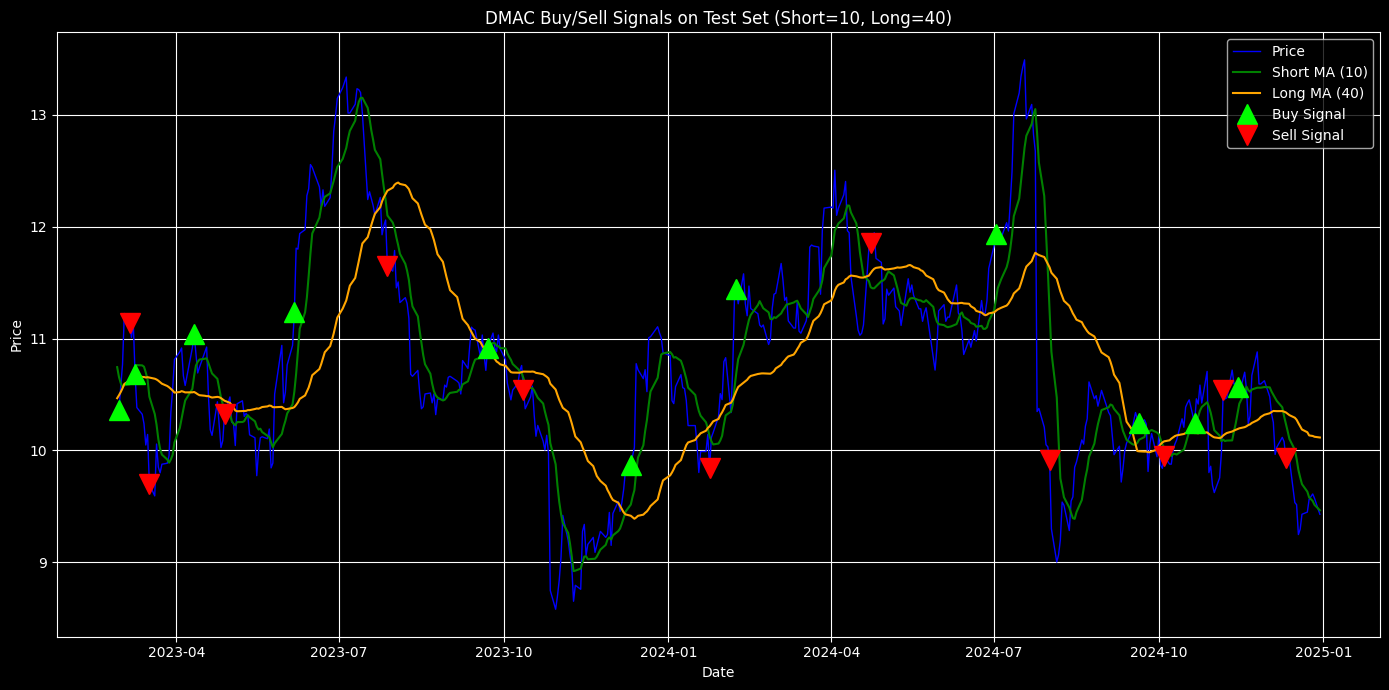

In [83]:
best_short = study.best_params['short_window']
best_long = study.best_params['long_window']
result_df = apply_dmac(test_data, best_short, best_long)

plt.figure(figsize=(14, 7))
plt.plot(result_df['Close'], label='Price', color='blue', linewidth=1)
plt.plot(result_df['short_ma'], label=f'Short MA ({best_short})', color='green')
plt.plot(result_df['long_ma'], label=f'Long MA ({best_long})', color='orange')

# Buy ▲ and Sell ▼ markers
plt.plot(result_df[result_df['buy']].index, result_df[result_df['buy']]['Close'],
         '^', markersize=14, color='lime', label='Buy Signal')
plt.plot(result_df[result_df['sell']].index, result_df[result_df['sell']]['Close'],
         'v', markersize=14, color='red', label='Sell Signal')

plt.title(f'DMAC Buy/Sell Signals on Test Set (Short={best_short}, Long={best_long})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dmac_signals_plot.png', dpi=300)
plt.show()

## Compare Strategy vs Buy & Hold

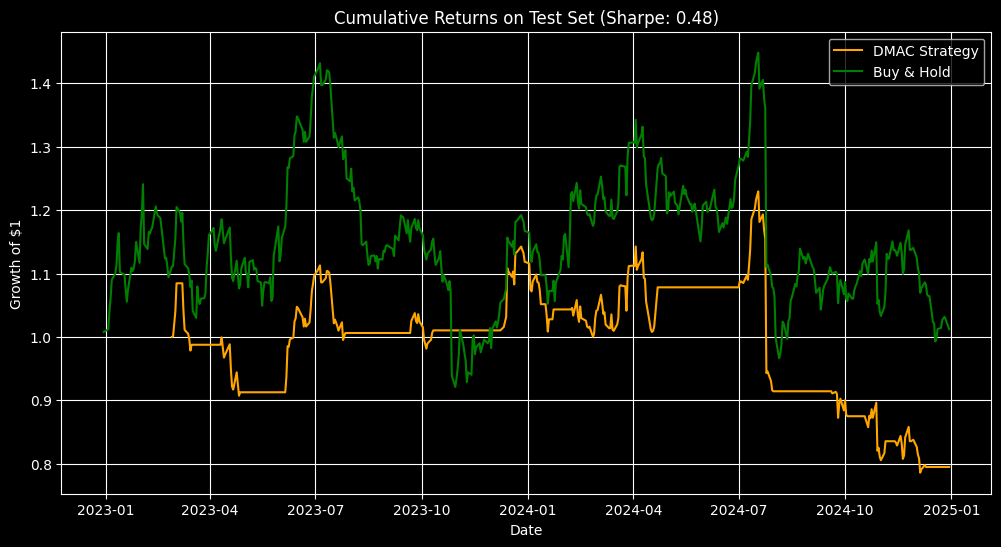

In [84]:
# Calculate cumulative returns for DMAC strategy (on test_data with best params)
cumulative_strategy = (1 + result_df['strategy_returns']).cumprod()

# Calculate buy & hold cumulative returns on full test_data (fixed, independent of params)
cumulative_bh = (1 + test_data['Close'].pct_change()).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(result_df.index, cumulative_strategy, label='DMAC Strategy', color='orange')
plt.plot(test_data.index, cumulative_bh, label='Buy & Hold', color='green')
plt.title(f'Cumulative Returns on Test Set (Sharpe: {study.best_value:.2f})')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.savefig('cumulative_returns_plot.png', dpi=300)
plt.show()

## Final Metrics Summary

In [85]:
start_capital = 1  # dollars

final_strategy_value = start_capital * cumulative_strategy.iloc[-1]
final_bh_value = start_capital * cumulative_bh.iloc[-1]

strategy_return_pct = (final_strategy_value - start_capital) / start_capital * 100
bh_return_pct = (final_bh_value - start_capital) / start_capital * 100

num_trades = int(result_df['buy'].sum() + result_df['sell'].sum())

# Prepare table data
table = [
    ["Strategy", "Final Value ($)", "Return (%)", "Total Trades"],
    ["DMAC Strategy", f"{final_strategy_value:.2f}", f"{strategy_return_pct:.2f}%", num_trades],
    ["Buy & Hold", f"{final_bh_value:.2f}", f"{bh_return_pct:.2f}%", "—"],
]

print(tabulate(table, headers="firstrow", tablefmt="rounded_grid"))

╭───────────────┬───────────────────┬──────────────┬────────────────╮
│ Strategy      │   Final Value ($) │ Return (%)   │ Total Trades   │
├───────────────┼───────────────────┼──────────────┼────────────────┤
│ DMAC Strategy │              0.79 │ -20.51%      │ 22             │
├───────────────┼───────────────────┼──────────────┼────────────────┤
│ Buy & Hold    │              1.01 │ 1.23%        │ —              │
╰───────────────┴───────────────────┴──────────────┴────────────────╯
